0.1 download sparse mouse single-cell data from https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6967/

0.2 Read and Operate the large sparse matrix on the cluster

1. down sample to N reads per cell (keep $\ge 90\%$ or $100,000$ reads/cell)


2. Gene Filter. throw out genes ($\mu < 0.05 x(M)$ and $\sigma < 0.05$)


3. $\log_2(1+X)$


4. z-score normalize

### 1. Preprocessing

In [1]:
from scipy.io import mmread,mminfo
import psutil

# the info of the matrix
info = mminfo(r'atlas/raw_counts.mtx')
print(info)
print(info[2]/(info[0]*info[1]))

# read in the matrix
data = mmread(r'atlas/raw_counts.mtx')

# memory status
info = psutil.virtual_memory()
print(info.total)
print(info.percent)

(29452, 139331, 483512215, 'coordinate', 'integer', 'general')
0.11782702279423168
202262147072
24.8


In [2]:
import preprocess as pp

In [3]:
mtx= pp.downsample(data,M=10000)

100%|██████████| 113803/113803 [42:33<00:00, 44.58it/s]


In [4]:
import numpy as np
genect = np.sum(mtx,axis=0)
genect = np.array(genect)[0]

In [5]:
mtx = mtx.tocsr()

In [6]:
mu,sigma = pp.musigma_sp(mtx)

100%|██████████| 1473/1473 [00:12<00:00, 120.57it/s]


In [7]:
# drop those with mu < 0.05 and sigma < 0.05
w = np.where((mu > 0.05) | (sigma > 0.05))

print(np.size(w))

w = tuple(np.array(w).reshape(-1))

mtx = mtx[w,:]

15025


In [8]:
mtx = pp.lognorm(mtx)

In [9]:
mu,sigma = pp.musigma_sp(mtx)

100%|██████████| 752/752 [00:11<00:00, 64.08it/s]


In [6]:
import numpy as np
import scipy as sp
mtx = np.load(f'normalized_X/X_noshuffle.npy',allow_pickle=True).all()

In [2]:
import preprocess as pp

In [12]:
mu,sigma = pp.musigma_sp(mtx)

100%|██████████| 752/752 [00:12<00:00, 61.14it/s]


In [49]:
zsn0 = np.load(f'normalized_X/z0value_noshuffle.npy')

In [7]:
mtx

<15025x113803 sparse matrix of type '<class 'numpy.float64'>'
	with 422495286 stored elements in Compressed Sparse Row format>

In [159]:
test = mtx[0:10,:].copy()

In [5]:
i = 1223
test = mtx[i,:]

N = test.shape[1] # total elements number
N1 = test.data.shape[0] # total nonzero elements number
N2 = N - N1 # zero elements number

# construnct new array for this 
newarray = np.concatenate( ( test.data , np.repeat([zsn0[i]],[N2]) ) )

# print the mean and stddev of the new array
print('mean is:', newarray.mean())
print('stddev is:', newarray.std())

mean is: -1.1188567810005883e-16
stddev is: 1.0


In [8]:
def toarr(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of cells with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    output: np.array, [cell_use number, gene num], already transposed for simple_planes.py
    '''
    nw = np.size(w)
    na = np.zeros([mtx.shape[0],nw])
    test = mtx[:,w]
    for i in range(mtx.shape[0]):
        na[i,:] = zsn0[i]
    na[test.nonzero()] = test.data
    
    return(na.T)

In [9]:
def toarr0(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of genes with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    for z-score check
    
    output: np.array, [gene num,cell_num],

    '''
    
    nw = np.size(w)
    na = np.zeros([nw,mtx.shape[1]])
    test = mtx[w,:]
    for i in range(nw):
        na[i,:] = zsn0[w[i]]
    na[test.nonzero()] = test.data
    
    return(na)

In [81]:
test = mtx[0:30,:].copy()

In [10]:
from tqdm import tqdm

def shufflesp_row_all(mtx,nn=20):
    '''
    shuffle each row of the mtx sparse matrix. 
    For efficiency, change to lil format first, do shuffle, 
    then change back to csr format
    nn is batch size
    
    output: shuffled csr matrix
    '''
    
    # step number
    stepnum = np.int( np.ceil( mtx.shape[0]/nn ) )
    
    # use small step, multi times to reduce the memory consumption
    
    for i in tqdm(range(stepnum)):
        
        temp = shufflesp_row(mtx[(i*nn):min([(i+1)*nn,mtx.shape[0]]),:])
        
        if i == 0:
            res = temp
        else:
            res = sp.sparse.vstack([res,temp])
        
    return(res)


def shufflesp_row(mtx):
    '''
    shuffle each row of the mtx sparse matrix. 
    For efficiency, change to lil format first, do shuffle, 
    then change back to csr format
    
    output: shuffled csr matrix
    '''
    mtx1 = mtx.tolil()
    
    ngenes = mtx.shape[0]
    
    index = np.arange(np.shape(mtx)[1])
    
    for i in range(ngenes):
        np.random.shuffle(index)
        mtx1[i,:] = mtx1[i,index]
    
    return(mtx1.tocsr())

In [11]:
mtx1 = shufflesp_row_all(mtx,nn=400)

100%|██████████| 38/38 [1:14:56<00:00, 118.33s/it]


In [12]:
np.save(f'normalized_X/X_shuffle.npy',mtx1)

In [5]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import sys
from scipy import sparse
from tqdm import tqdm
from sklearn.cluster import KMeans

In [6]:
def toarr(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of cells with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    output: np.array, [cell_use number, gene num], already transposed for simple_planes.py
    '''
    nw = np.size(w)
    na = np.zeros([mtx.shape[0],nw])
    test = mtx[:,w]
    for i in range(mtx.shape[0]):
        na[i,:] = zsn[i]
    na[test.nonzero()] = test.data
    
    return(na.T)


def plane_cutting(X,trials, cell_sample,cluster_param,zsn):
    feature_weights = np.hstack([PCMBK(X,cell_sample,cluster_param,zsn) for k in tqdm(range(trials))])
    return feature_weights


def PCMBK(X,cell_sample,k_sub,zsn):
    n_genes,n_cells = X.shape
    cell_use = np.random.choice(np.arange(n_cells),cell_sample,replace = False)
    k_sub_i = np.random.randint(k_sub[0],k_sub[1])
    #k_guess = KMeans(k_sub_i).fit_predict(X[cell_use,:])
    k_guess = KMeans(k_sub_i).fit_predict(toarr(X,cell_use,zsn))
    gnout = np.array([one_tree(X,cell_use,k_guess,ikk1,ikk2,zsn) for ikk1 in np.unique(k_guess) for ikk2 in np.unique(k_guess) if ikk1<ikk2 ])
    return np.hstack(gnout)


def one_tree(X,cu,k_guess,ik1,ik2,zsn,md = 1):
    #Xit = X[cu,:]      
    Xit = toarr(X,cu,zsn)        
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = md)
    XTT = Xit[np.logical_or(k_guess==ik1,k_guess==ik2),:]
    KTT = k_guess[np.logical_or(k_guess==ik1,k_guess==ik2)]
    clf.fit(XTT,KTT)
    feature_pick = np.flatnonzero(clf.feature_importances_)
    return feature_pick

In [7]:
X = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/X_noshuffle.npy',allow_pickle=True).all()
zsn = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/z0value_noshuffle.npy')

In [ ]:
iterations = 3000 
n_sub = 500
CP = [20,75]
FW=plane_cutting(X[0:500,:],iterations,n_sub,CP,zsn)
#np.save(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/Out/gx_{ki}.npy',FW)

In [12]:
n_genes,n_cells = X[0:1000,:].shape

In [13]:
n_genes

1000

In [14]:
n_cells

113803

In [29]:
from time import time

M=100
N=1000
time0 = time()

XX = X[0:M,:]

n_genes,n_cells = XX.shape

cell_use = np.random.choice(np.arange(n_cells),N,replace = False)

k_sub_i = np.random.randint(20,70)

k_guess = KMeans(k_sub_i).fit_predict(toarr(XX,cell_use,zsn))

gnout = np.array([one_tree(XX,cell_use,k_guess,ikk1,ikk2,zsn) for ikk1 in np.unique(k_guess) for ikk2 in np.unique(k_guess) if ikk1<ikk2 ])

print(time()-time0)

9.45806074142456


In [32]:
for ki in range(5):
    X = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/X_noshuffle.npy',allow_pickle=True).all()
    M = 100
    XX = X[0:M,:]
    zsn = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/z0value_noshuffle.npy')
    iterations = 72
    n_sub = 1000
    CP = [20,75]
    FW=plane_cutting(XX,iterations,n_sub,CP,zsn)
    np.save(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/Out/gx_{ki}.npy',FW)



  0%|          | 0/72 [00:00<?, ?it/s]

  1%|▏         | 1/72 [00:01<01:52,  1.58s/it]

  3%|▎         | 2/72 [00:17<06:50,  5.87s/it]

  4%|▍         | 3/72 [00:33<10:06,  8.79s/it]

  6%|▌         | 4/72 [00:37<08:22,  7.40s/it]

  7%|▋         | 5/72 [00:52<10:55,  9.79s/it]

  8%|▊         | 6/72 [00:54<08:13,  7.47s/it]

 10%|▉         | 7/72 [01:01<07:58,  7.37s/it]

 11%|█         | 8/72 [01:09<07:57,  7.46s/it]

 12%|█▎        | 9/72 [01:15<07:31,  7.17s/it]

 14%|█▍        | 10/72 [01:24<07:47,  7.54s/it]

 15%|█▌        | 11/72 [01:38<09:47,  9.63s/it]

 17%|█▋        | 12/72 [01:49<09:58,  9.97s/it]

 18%|█▊        | 13/72 [02:05<11:31, 11.73s/it]

 19%|█▉        | 14/72 [02:13<10:24, 10.76s/it]

 21%|██        | 15/72 [02:29<11:34, 12.19s/it]

 22%|██▏       | 16/72 [02:41<11:17, 12.10s/it]

 24%|██▎       | 17/72 [02:51<10:38, 11.61s/it]

 25%|██▌       | 18/72 [02:53<07:49,  8.69s/it]

 26%|██▋       | 19/72 [03:01<07:26,  8.43s/it]

 28%|██▊       | 20/72 [03:03<05:30,

  8%|▊         | 6/72 [00:38<06:39,  6.05s/it]

 10%|▉         | 7/72 [00:44<06:30,  6.01s/it]

 11%|█         | 8/72 [00:57<08:33,  8.02s/it]

 12%|█▎        | 9/72 [01:08<09:18,  8.87s/it]

 14%|█▍        | 10/72 [01:13<08:04,  7.81s/it]

 15%|█▌        | 11/72 [01:19<07:28,  7.35s/it]

 17%|█▋        | 12/72 [01:28<07:38,  7.64s/it]

 18%|█▊        | 13/72 [01:42<09:35,  9.75s/it]

 19%|█▉        | 14/72 [01:57<10:42, 11.08s/it]

 21%|██        | 15/72 [02:10<11:19, 11.91s/it]

 22%|██▏       | 16/72 [02:24<11:35, 12.42s/it]

 24%|██▎       | 17/72 [02:38<11:44, 12.81s/it]

 25%|██▌       | 18/72 [02:48<10:56, 12.16s/it]

 26%|██▋       | 19/72 [02:50<08:05,  9.15s/it]

 28%|██▊       | 20/72 [02:53<06:18,  7.29s/it]

 29%|██▉       | 21/72 [03:01<06:15,  7.37s/it]

 31%|███       | 22/72 [03:07<05:55,  7.11s/it]

 32%|███▏      | 23/72 [03:22<07:44,  9.48s/it]

 33%|███▎      | 24/72 [03:32<07:35,  9.49s/it]

 35%|███▍      | 25/72 [03:35<05:57,  7.61s/it]

 36%|███▌      | 26/72 [

In [31]:
3600/50

72.0

In [33]:
base_dir = '/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/Out/'
FW = np.hstack([np.load(base_dir+f'gx_{k}.npy') for k in range(5)])
gx,_ = np.histogram(FW, np.arange(FW.max()+1), density = True)

FW = np.hstack([np.load(base_dir+f'gs_{k}.npy') for k in range(5)])
gs,_ = np.histogram(FW, np.arange(FW.max()+1), density = True)

z_d = (gx-gs.mean())/gs.std()

In [35]:
w = np.where(z_d > 1)

In [41]:
z_d.shape

(99,)

In [40]:
import matplotlib.pyplot as plt

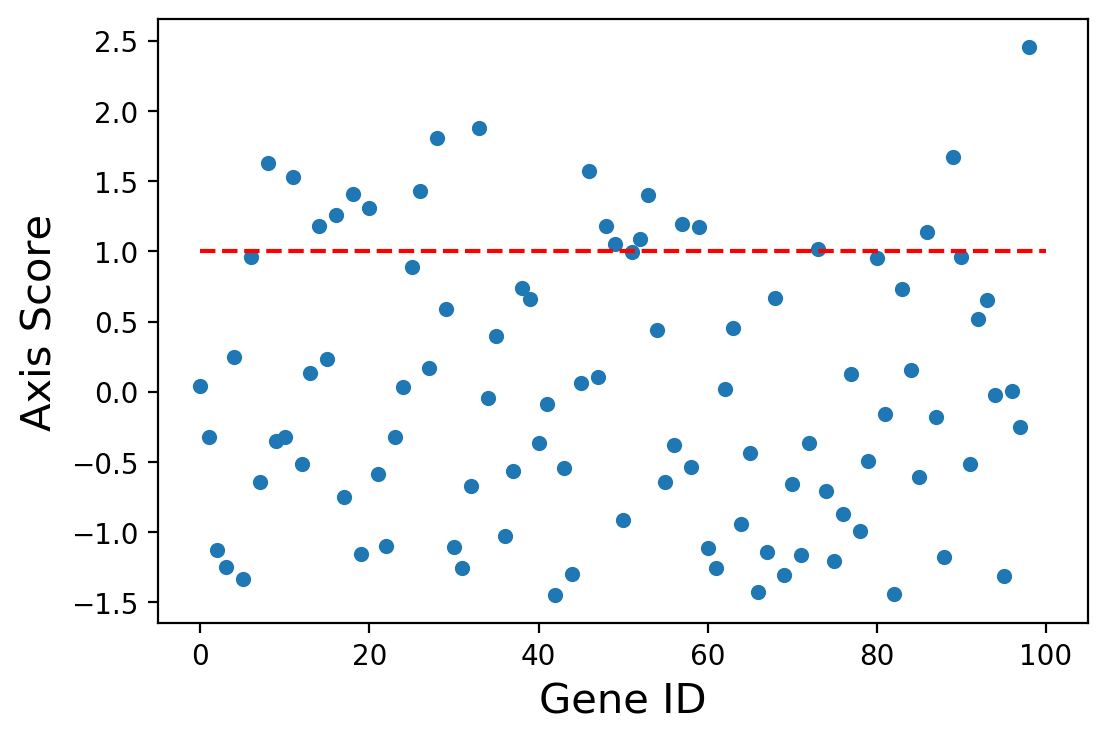

In [46]:
plt.figure(dpi=200)
plt.scatter(np.arange(99),z_d,s=20)
plt.xlabel('Gene ID', fontsize = 15)
plt.ylabel('Axis Score',fontsize=15)
plt.hlines(1,0,100,colors='r',linestyles='dashed')
plt.show()

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
a = np.random.normal(size=113803)

(array([2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 5.000e+00,
        1.100e+01, 1.000e+01, 1.000e+01, 1.400e+01, 2.100e+01, 3.300e+01,
        2.900e+01, 3.900e+01, 6.000e+01, 7.900e+01, 1.070e+02, 1.160e+02,
        1.560e+02, 1.720e+02, 2.380e+02, 3.030e+02, 3.770e+02, 4.200e+02,
        5.120e+02, 5.990e+02, 7.590e+02, 8.500e+02, 9.520e+02, 1.078e+03,
        1.228e+03, 1.426e+03, 1.666e+03, 1.865e+03, 2.076e+03, 2.245e+03,
        2.445e+03, 2.716e+03, 2.994e+03, 3.046e+03, 3.245e+03, 3.356e+03,
        3.647e+03, 3.617e+03, 3.690e+03, 3.991e+03, 4.073e+03, 3.862e+03,
        3.962e+03, 3.831e+03, 3.804e+03, 3.716e+03, 3.651e+03, 3.489e+03,
        3.347e+03, 3.147e+03, 3.003e+03, 2.670e+03, 2.583e+03, 2.358e+03,
        2.146e+03, 1.902e+03, 1.696e+03, 1.581e+03, 1.341e+03, 1.184e+03,
        1.019e+03, 8.730e+02, 7.680e+02, 6.520e+02, 5.370e+02, 4.290e+02,
        3.870e+02, 3.190e+02, 2.630e+02, 2.150e+02, 1.680e+02, 1.380e+02,
        1.050e+02, 1.020e+02, 5.900e+0

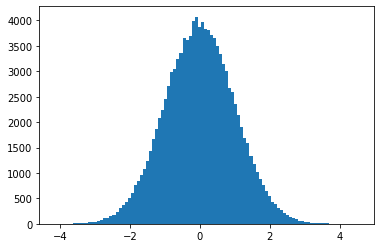

In [7]:
plt.hist(a,bins=100)

In [8]:
X = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/X_noshuffle.npy',allow_pickle=True).all()
zsn = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/z0value_noshuffle.npy')

In [9]:
X

<15025x113803 sparse matrix of type '<class 'numpy.float64'>'
	with 422495286 stored elements in Compressed Sparse Row format>

In [16]:
import sparse_utils as su2

In [19]:
test = toarr0(X,[0],zsn)

In [18]:
def toarr0(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of genes with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    for z-score check
    
    output: np.array, [gene num,cell_num],

    '''
    
    nw = np.size(w)
    na = np.zeros([nw,mtx.shape[1]])
    test = mtx[w,:]
    for i in range(nw):
        na[i,:] = zsn[w[i]]
    na[test.nonzero()] = test.data
    
    return(na)

In [35]:
test = toarr0(X,[1],zsn)

In [38]:
null = np.ndarray([100,113803])

In [39]:
null

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
for i in range(100):
    null[i] = a


In [43]:
np.save(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/syne_null.npy',null)

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import sys
from scipy import sparse
from tqdm import tqdm
from sklearn.cluster import KMeans

def toarr0(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of genes with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    for z-score check
    
    output: np.array, [gene num,cell_num],

    '''
    
    nw = np.size(w)
    na = np.zeros([nw,mtx.shape[1]])
    test = mtx[w,:]
    for i in range(nw):
        na[i,:] = zsn[w[i]]
    na[test.nonzero()] = test.data
    
    return(na)

def toarr(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of cells with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    output: np.array, [cell_use number, gene num], already transposed for simple_planes.py
    '''
    nw = np.size(w)
    na = np.zeros([mtx.shape[0],nw])
    test = mtx[:,w]
    for i in range(mtx.shape[0]):
        na[i,:] = zsn[i]
    na[test.nonzero()] = test.data
    
    return(na.T)


def plane_cutting(X,trials, cell_sample,cluster_param):
    feature_weights = np.hstack([PCMBK(X,cell_sample,cluster_param) for k in tqdm(range(trials))])
    return feature_weights


def PCMBK(X,cell_sample,k_sub):
    n_cells,n_genes = X.shape
    cell_use = np.random.choice(np.arange(n_cells),cell_sample,replace = False)
    k_sub_i = np.random.randint(k_sub[0],k_sub[1])
    k_guess = KMeans(k_sub_i).fit_predict(X[cell_use,:])
    #k_guess = KMeans(k_sub_i).fit_predict(toarr(X,cell_use,zsn))
    gnout = np.array([one_tree(X,cell_use,k_guess,ikk1,ikk2) for ikk1 in np.unique(k_guess) for ikk2 in np.unique(k_guess) if ikk1<ikk2 ])
    return np.hstack(gnout)


def one_tree(X,cu,k_guess,ik1,ik2,md = 1):
    Xit = X[cu,:]  
    #Xit = toarr(X,cu,zsn)        
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = md)
    XTT = Xit[np.logical_or(k_guess==ik1,k_guess==ik2),:]
    KTT = k_guess[np.logical_or(k_guess==ik1,k_guess==ik2)]
    clf.fit(XTT,KTT)
    feature_pick = np.flatnonzero(clf.feature_importances_)
    return feature_pick

In [3]:
X = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/X_noshuffle.npy',allow_pickle=True).all()
zsn = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/z0value_noshuffle.npy')

In [5]:
M = 100
XX = toarr0(X,range(M),zsn)
XX=XX.T

In [6]:
XX.shape

(113803, 100)

In [ ]:
for ki in range(20):
    iterations = 100
    n_sub = 1000
    CP = [20,75]
    FW=plane_cutting(XX,iterations,n_sub,CP)
    np.save(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/Out/gd1_{ki}.npy',FW)

 99%|█████████▉| 99/100 [02:36<00:01,  1.16s/it]